# Time-lagged Independent component analysis using PyEMMA
# Hybrid state formation

In [75]:
import matplotlib.pyplot as plt
import numpy as np
import pyemma
import mdtraj as mt
import nglview as nv
import os

# Documentation for pyemma: http://emma-project.org/latest/
# Documentation for mdtraj: http://mdtraj.org/1.9.3/
# Documentation for nglview: http://nglviewer.org/nglview/latest/


In [59]:
# Set up all filenames as a list stored in the "files" variable

ddirs = [f'../AP-tRNA_L11_H89_P{i}/' for i in range(1, 5)]
first_file = 1
last_files = [364, 370, 366, 343]

top = ddirs[0] + 'min_P.pdb'  # topology file with atom names, indices, etc.

files = []
for ddir, last_file in zip(ddirs, last_files):
    file_range = range(first_file, last_file + 1)
    files = files + [ddir + f'part{n:04}.xtc' for n in file_range]
    

In [60]:
# Create array of distances between phosphates of AtRNA and PtRNA
AtRNA = np.arange(0, 76)      # AtRNA phosphate indices
PtRNA = np.arange(76, 119)    # PtRNA phosphate indices
distances = np.array([[x, y] for x in AtRNA for y in PtRNA])

# Load distances array into pyemma feature object
dist_feat = pyemma.coordinates.featurizer(top)
dist_feat.add_distances(distances, periodic=False)

# Load .xtc data and pyemma feature object and store in variable "dist_data"
dist_data = pyemma.coordinates.source(files, features=dist_feat)


In [ ]:
# Runs TICA on the dataset and saves the results to file 
# Can skip to next cell if you don't want to wait for the calculation

# TICA covariance matrices, eigenvectors, eigenvalues, etc. are all stored in "tica" variable
# "tica_output" stores the ICs
# "tica_output" is a list of numpy arrays; each array corresponds to the IC values in an .xtc file

lag = 250  # lag time
stride = 10

tica = pyemma.coordinates.tica(dist_data, lag=lag, stride=stride)
tica_output = tica.get_output()


# Saving analysis results using numpy
# Pyemma also has its own API for saving results; I didn't really look into it

np.save('APdist_4Xdata_tica_l250_s10.npy', tica)   # Save tica object to file
np.save('APdist_4Xdata_tica_output_l250_s10.npy', tica_output)   # Save tica output to file


In [6]:
# Loads the saved results back into Python

tica = np.load('APdist_4Xdata_tica_l250_s10.npy', allow_pickle=True)[()]
tica_output = np.load('APdist_4Xdata_tica_output_l250_s10.npy', allow_pickle=True)[()]


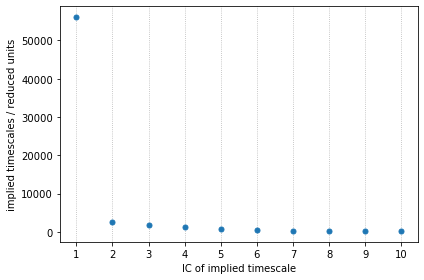

In [46]:
# Plot of the implied timescales of the first 10 ICs
# Check these values (or just the first timescale) for various lag times to see when they converge

first_IC = 1    # first IC timescale to plot
last_IC = 10    # last IC timescale to plot
lag = 250
time_step = 2  # time_step of each frame (2 ps/reduced units based on the gromacs log file)


timescales = tica.timescales[first_IC-1:last_IC]   # tica implied timescales

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    
ax.errorbar(range(ndx1 + 1, ndx2 + 1), timescales, fmt='.', markersize=10)

ax.set_xticks(range(ndx1 + 1, ndx2 + 1))
ax.grid(True, axis='x', linestyle=':')

ax.set_xlabel('IC of implied timescale')
ax.set_ylabel('implied timescales / reduced units')

fig.tight_layout()

# Increase dpi value to create higher resolution plot 
# Then right click on plot for options to copy or save image
# Easiest way I've found to save plots (easier than using "fig.savefig")
fig.set_dpi(72)


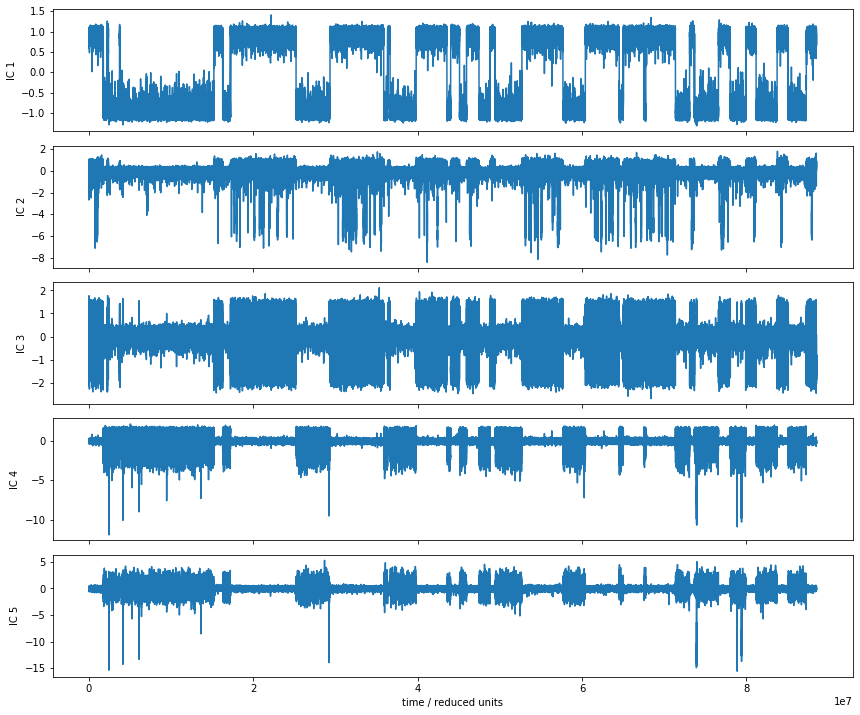

In [43]:
# Plots the first five ICs as a function of time

n_ICs = 5       # number of ICs to plot
time_step = 2   # time_step of each frame (2 ps/reduced units based on the gromacs log file)
skip = 100     # frames to skip when plotting (plotting all frames can take a long time)


tica_concatenated = np.concatenate(tica_output)[::skip]   # concatenate tica_output list into one array

fig, axes = plt.subplots(n_ICs, 1, figsize=(12, 2*n_ICs), sharex=True)

time = time_step * skip * np.arange(tica_concatenated.shape[0])

for i, (ax, IC) in enumerate(zip(axes.flat, tica_concatenated.T)):
    ax.plot(time, IC)
    ax.set_ylabel(f'IC {i+1}')

axes[-1].set_xlabel('time / reduced units')

fig.tight_layout()


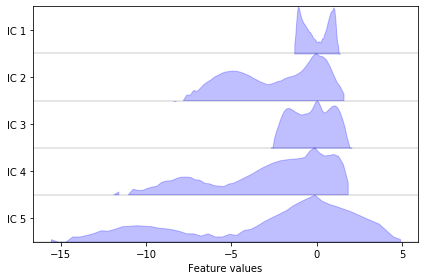

In [47]:
# Plot the marginal distribution of values for the first five ICs

n_ICs = 5       # number of ICs to plot
skip = 100      # frames to skip when plotting (plotting all frames can take a long time)


tica_concatenated = np.concatenate(tica_output)[::skip]    # concatenate tica_output list into one array

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

pyemma.plots.plot_feature_histograms(
    tica_concatenated[:, :n_ICs],
    ax=ax,
    feature_labels=[f'IC {i}' for i in range(1, n_ICs + 1)],
    ylog=True,
    ignore_dim_warning=True)

fig.tight_layout()


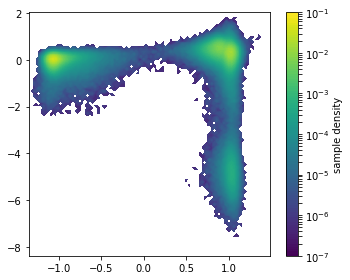

In [48]:
# Plot the joint distribution of values for ICs 1 and 2

first_IC = 1    # first IC to plot
second_IC = 2   # second IC to plot
skip = 25       # frames to skip when plotting (plotting all frames can take a long time)

tica_concatenated = np.concatenate(tica_output)[::skip]    # concatenate tica_output list into one array

fig, ax = plt.subplots(1, 1, figsize=(5, 4))

pyemma.plots.plot_density(tica_concatenated[:, first_IC-1],
                          tica_concatenated[:, second_IC-1],
                          ax=ax, 
                          logscale=True)
axes[1].set_xlabel(f'IC {first_IC}')
axes[1].set_ylabel(f'IC {second_IC}')

fig.tight_layout()


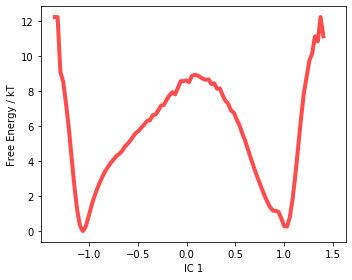

In [56]:
# Plot free energy along IC 1

IC = 1          # IC number
skip = 25       # frames to skip when plotting (plotting all frames can take a long time)
bins = 100      # number of bins to use for calculating free energy


tica_concatenated = np.concatenate(tica_output)[::skip]    # concatenate tica_output list into one array

z, xedge = np.histogram(tica_concatenated[:, IC - 1], bins=bins, weights=None)   # calculates histogram
x = 0.5 * (xedge[:-1] + xedge[1:])
z = z.T
f = pyemma.plots.plots2d._to_free_energy(z, minener_zero=True)   # converts histogram to free energy (units of kT)

fig, ax = plt.subplots(1, 1, figsize=[5, 4])

ax.plot(x, f, color='red', linewidth=4, alpha=0.7)
ax.set_xlabel(f'IC {IC}')
ax.set_ylabel('Free Energy / kT')

fig.tight_layout()


In [ ]:
from collections import defaultdict
from datetime import datetime as dt

def tp_prob(coord, A_range, B_range, bins=100, verbose=False):
    
    '''
    Calculates the probability of a being on a transition path for a given series of coordinates 
    (e.g. for a given IC)
    
    Parameters:
    --------------------
    coord (numpy array of floats):
        series of coordinates
    A_range (two-item list of floats):
        range of coordinate values which define one of the transitionendpoints
    B_range (two-item list of floats):
        range of coordinate values which define the other transition endpoint
    bins (int):
        number of bins to partition the coordinate values
    verbose (bool):
        print calculation times if True
    
    Returns:
    --------------------
    coord_values (numpy array of floats):
        range of coordinate values
    probs (numpy array of floats):
        probability of being on a transition path for each item in coord_value
    '''
    
    # Discretize the coordinates based on the number of bins
    # Done through multiplying coordinates by a factor and rounding to integers
    coord_diff = np.max(coord[::100]) - np.min(coord[::100])
    factor = bins/coord_diff
    coord_states = np.rint(coord*factor).astype(int)
    coord_values = (np.array(sorted(set(coord_states))))/factor
    
    # Set the transition endpoints
    A1 = A_range[0]
    A2 = A_range[1]
    B1 = B_range[0]
    B2 = B_range[1]
    A = set(np.arange(int(A1*factor), int(A2*factor)))
    B = set(np.arange(int(B1*factor), int(B2*factor)))
    
    # If a coordinate value occurs between different endpoints, increment the count for that value in "trans_dict"
    # If a coordinate value occurs between the same endpoints, don't increment the count in "trans_dict"
    # In both cases, increment the count in "total_dict"
    total_dict = defaultdict(int)
    trans_dict = defaultdict(int)
    temp_dict = defaultdict(int)
    initial = None
    final = None
    for n, state in enumerate(coord_states):
        if verbose and n % 1000000 == 0:
            print(n, ' Time:', dt.now()) 
        if state in A:
            initial = final
            final = 'A'
            if initial == None:
                continue
            if (initial == 'A' and final == 'B') or (initial == 'B' and final == 'A'):
                for key, val in temp_dict.items():
                    trans_dict[key] += val
            else:
                assert initial == final
            temp_dict = defaultdict(int)
        elif state in B:
            initial = final
            final = 'B'
            if initial == None:
                continue
            if (initial == 'A' and final == 'B') or (initial == 'B' and final == 'A'):
                for key, val in temp_dict.items():
                    trans_dict[key] += val
            else:
                assert initial == final
            temp_dict = defaultdict(int)
        else:
            if initial == None:
                continue
            temp_dict[state] += 1
        total_dict[state] += 1

    # Divide the counts in "trans_dict" by the counts in "total_dict" to obtain probabilities
    probs = []
    for i in total_dict.keys():
        p = trans_dict[i]/total_dict[i]
        probs.append((i, p))
    probs.sort(key=lambda x: x[0])
    
    probs = [item[1] for item in probs]
    
    return coord_values, probs


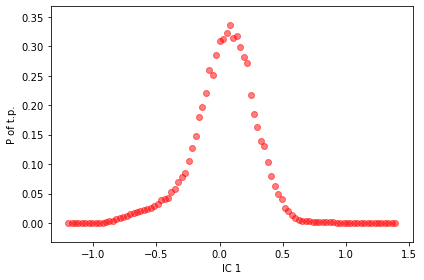

In [68]:
# Plot probability of being on a transition path for IC 1

IC = 1                     # IC coordinate
A_range = [-1.04, -1]      # 1st transition endpoint based on local minimum in free energy plot
B_range = [1.02, 1.06]     # 2nd transition endpoint based on local minimum in free energy plot


tica_concatenated = np.concatenate(tica_output)
IC_coords = tica_concatenated[:, IC - 1]

coord_values, probs = tp_prob(IC_coords, A_range, B_range, bins=100, verbose=False)

fig, ax = plt.subplots(1, 1, figsize=[6, 4])

ax.scatter(coord_values[10:-10], probs[10:-10], color='red', alpha=0.5)

ax.set_xlabel('IC 1')
ax.set_ylabel('P of t.p.')

fig.tight_layout()


In [73]:

def visualize_IC_range(IC, min_val, max_val, tica_output, files, top, samples=250):
    '''
    Returns randomly sampled frames of the MD data which have the specified IC values

    Parameters:
    --------------
    IC (int):
        IC of interest
    min_val (float):
        minimum possible value of the IC in the sampled frames
    max_val (float):
        maximum possible value of the IC in the sampled frames
    tica_output (list of numpy arrays):
        UNCONCATENATED list of ALL IC values
    files (list of strings):
        .xtc filenames composing the trajectory
    top (string):
        topology file associated with .xtc files
    samples (int):
        number of sampled frames to return

    Returns:
    --------------
    traj (mdtraj object):
        sampled frames
    widget (nglview object):
        visualization of the sampled frames; displayed directly in Jupyter Notebook
    '''

    indices_list = []
    for ics in tica_output:
        ic = ics[:, IC - 1]
        selection = (ic > min_val) & (ic < max_val)
        indices = np.argwhere(selection).flatten()
        indices_list.append(indices)

    weights = np.array([len(indices) for indices in indices_list])
    if all(weight == 0 for weight in weights):
        print('No MD data with the specified IC values found')
        return
    weights = weights/np.sum(weights)

    frames = []
    for _ in range(samples):
        n = np.random.choice(np.arange(len(indices_list)), p=weights)
        i = np.random.choice(indices_list[n])
        frames.append((n, i))

    frames = np.array(frames)
    traj = pyemma.coordinates.save_traj(files, frames, outfile=None, top=top)

    widget = nv.show_mdtraj(traj)
    widget.clear_representations()
    widget.add_hyperball('all', radius=5)

    return traj, widget


In [72]:
# Visualize states for which -1.1 < IC1 < -1.0
# Need to rerun to display widget

traj, widget = visualize_IC_range(IC=1, min_val=-1.1, max_val=-1, 
                                  tica_output=tica_output, files=files, top=top, 
                                  samples=250)

AtRNA = np.arange(0, 76)
PtRNA = np.arange(76, 119)

widget.clear_representations()
widget.add_hyperball(AtRNA, radius=5)                    # AtRNA is colored orange
widget.add_hyperball(PtRNA, color='blue', radius=5)      # PtRNA is colored blue

widget


NGLWidget(max_frame=249)

In [74]:
# Visualize states for which 1.0 < IC1 < 1.1
# Need to rerun to display widget

traj, widget = visualize_IC_range(IC=1, min_val=1, max_val=1.1, 
                                  tica_output=tica_output, files=files, top=top, 
                                  samples=250)

AtRNA = np.arange(0, 76)
PtRNA = np.arange(76, 119)

widget.clear_representations()
widget.add_hyperball(AtRNA, radius=5)                    # AtRNA is colored orange
widget.add_hyperball(PtRNA, color='blue', radius=5)      # PtRNA is colored blue

widget


NGLWidget(max_frame=249)

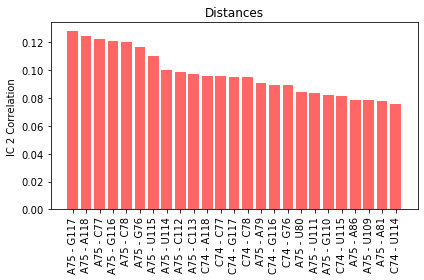

In [79]:
# Plots the largest correlations of IC 2 with distances between specific residues (i.e. "feature components")

IC = 2            # IC of interest
max_feats = 25    # Highest number of features to plot


corr = tica.feature_TIC_correlation[:, IC - 1]     # Feture correlations for the given IC
corr = [(n, i) for n, i in enumerate(corr) if not np.isnan(i)]
corr.sort(key=lambda x: abs(x[1]), reverse=True)   # Sort based on absolute value of correlations

feat_comps = dist_feat.describe()                  # Name of feature components

# Matches feature component names to correlation values
labels = []
for n, i in corr[:max_feats]:
    feat_comp = feat_comps[n]
    items = feat_comp.split()
    residue1 = items[1] + items[4]       # Residue names based on character index in string
    residue2 = items[6] + items[9]       # Residue names based on character index in string
    label = ' - '.join([residue1, residue2])
    labels.append(label)

corr = [abs(item[1]) for item in corr]   # Take the absolute of correlations

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.bar(labels, corr[:max_feats], color='red', alpha=0.6)
ax.set_xticklabels(labels, rotation=90)
ax.set_ylabel(f'IC {IC} Correlation')
ax.set_title('Distances')

fig.tight_layout()
